In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
# from diffpy.pdfgui.tui import LoadProject
# from diffpy.pdfgui.control.pdfguicontrol import PDFGuiControl
# from diffpy.pdffit2.pdffit2 import calculationError

from IPython.display import clear_output
# from tqdm.auto import tqdm
import time
import shutil
import yaml

In [2]:
%matplotlib widget

In [3]:
def tqdm_sleep_sec(t, message='Sleep'):
    import datetime
    from tqdm import tqdm
    now = datetime.datetime.now()
    print(f'\nSleep for a while: {t} seconds.')
    print(f'Waiting starts at {now}')
    for i in tqdm(range(0,100), desc=message):
        time.sleep(t/100)

In [4]:
def get_timestamp_by_fn(fn, time_key='2025'):
    fn_basename = os.path.basename(str(fn))
    index = fn_basename.find(time_key)
    timestamp = fn_basename[index:index+15]
    return timestamp

In [5]:
from pdfstream.io import load_array
from pdfstream.transformation.io import load_pdfconfig, write_pdfgetter
from pdfstream.transformation.main import get_pdf
from diffpy.pdfgetx import PDFConfig
from diffpy.pdfgetx.pdfgetter import PDFConfigError
import typing


## Copy from https://github.com/NSLS2/xpd-profile-collection-ldrd20-31/blob/main/scripts/_get_pdf.py
def transform_bkg(
    cfg_file,
    data_file: str,
    output_dir: str = ".",
    plot_setting: typing.Union[str, dict] = None,
    test: bool = False,
    gr_fn: str = '/home/xf28id2/Documents/test.gr', 
    ) -> typing.Dict[str, str]:
    
    """Transform the data."""
    if isinstance(cfg_file,str):
        pdfconfig = load_pdfconfig(cfg_file)
    else:
        pdfconfig = cfg_file
    
    if type(data_file) is str:
        chi = load_array(data_file)
    elif type(data_file) is np.ndarray:
        chi = data_file
    
    # try:
    #     pdfgetter = get_pdf(pdfconfig, chi, plot_setting=plot_setting)
    # except PDFConfigError:
    #     pdfgetter = get_pdf(pdfconfig, chi, plot_setting='OFF')

    if test:
        pdfgetter = get_pdf(pdfconfig, chi, plot_setting='OFF')

    else:
        pdfgetter = get_pdf(pdfconfig, chi, plot_setting=plot_setting)
    
    # filename = Path(data_file).stem
    # dct = write_pdfgetter(output_dir, filename, pdfgetter)
    
    dct = write_pdfgetter(output_dir, gr_fn, pdfgetter)
    
    # if not test:
    #     plt.show()
    
    return dct, pdfconfig

/opt/miniconda3/envs/pdfstream_310/lib/python3.10/site-packages/pdfstream/data.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [6]:
import importlib
auto_bkg = importlib.import_module("auto_bkg").auto_bkg

def get_gr(iq_data, cfg_fn, bkg_fn, output_dir, gr_fn_prefix, 
           is_autobkg=True, is_autoqmax=True, 
           ave_cutoff=0.009, window_length=15):
    # run = tiled_client[uid]
    
    ## run.start['sample_composition'] is a dict but pdfconfig takes a string for composition 
    # scan_com = run.start['sample_composition']

    pdfconfig = PDFConfig()
    pdfconfig.readConfig(cfg_fn)

    # pdfconfig.composition = composition_maker(scan_com)

    ## There is also a string for composition in run.start. Updated by CHLin on 2025/06/16
    # try:
    #     pdfconfig.composition = run.start['composition_string']
    #     print(f'\n\nFound composition as {run.start["composition_string"] = }')

    # except (KeyError):
    #     pdfconfig.composition = 'Ni1.0'
    #     print(f'\n\nCan not find sample composition in run.start. Use "Ni1.0" instead.')

    
    ## Use auto_bkg to repalce the bkg in pdfconfig
    if is_autobkg:
        a_bkg = auto_bkg(iq_data, bkg_fn)
        a_bkg.pdload_data(skiprows=1, sep=' ', names=['Q', 'I'])
        a_bkg.pdload_bkg(skiprows=1, sep=' ', names=['Q', 'I'])
        res = a_bkg.min_integral()
        pdfconfig.bgscales[0] = res.x
        print(f'\nUpdate {pdfconfig.bgscales[0] = } by auto_bkg\n')
        # a_bkg.plot_sub()

    if is_autoqmax:

        pdfconfig.backgroundfiles = bkg_fn
        pdfconfig.qmax = pdfconfig.qmaxinst-5
        pdfconfig.outputtypes = ['fq']
        
        sqfqgr_path, pdfconfig = transform_bkg(
            pdfconfig, iq_data, 
            output_dir = output_dir, 
            plot_setting={'marker':'.','color':'red'}, test=True, 
            gr_fn=gr_fn_prefix)

        
        autoqmax=find_qmax(sqfqgr_path['fq'],  ave_cutoff=ave_cutoff, window_length=window_length)
        pdfconfig.qmax = autoqmax
        pdfconfig.outputtypes = ['gr']
        
        sqfqgr_path, pdfconfig = transform_bkg(
            pdfconfig, iq_data, 
            output_dir = output_dir, 
            plot_setting={'marker':'.','color':'green'}, test=False, 
            gr_fn=gr_fn_prefix)
        
    
    else:
        pdfconfig.backgroundfiles = bkg_fn
        sqfqgr_path, pdfconfig = transform_bkg(
                    pdfconfig, iq_data, 
                    output_dir = output_dir, 
                    plot_setting={'marker':'.','color':'green'}, test=False, 
                    gr_fn=gr_fn_prefix)
    
    print(f'\n*** {os.path.basename(sqfqgr_path["gr"])} saved!! ***\n')

    return sqfqgr_path, pdfconfig

In [7]:
from scipy.signal import savgol_filter

def count_header(filename):
    # count header 
    with open (filename,'r') as myfile:
        data = myfile.read().splitlines()
    count = 0
    for i, lines in enumerate(data):
        if lines == '#### start data':
            count =i
    return count+2

def find_qmax(filename, ave_cutoff=8e-03, window_length=21, is_plot=False):
    
    header_count=count_header(filename)
    q, f = np.loadtxt(filename, skiprows= header_count, unpack=True)
    qmax = q[-1]
    fhat = savgol_filter(f, window_length, 3)
    fdiff=f-fhat
    zero_cross = np.where(np.diff(np.signbit(fhat)))[0]
    z=zero_cross[::-1]
    for i, i_zero in enumerate(z):
        ave=np.average(abs(fdiff[i_zero:]))

        if ave > ave_cutoff:
            print(i_zero, q[i_zero], ave)
        else:
            qmax = np.round(q[z[i-1]],1)
            print(i_zero, q[i_zero], ave)
            print(f'qmax ={qmax}')
            break    

    if is_plot:
        plt.figure(figsize=(16,8))            
        plt.plot(q,f)
        plt.plot(q, fhat, 'r')
    
        plt.plot(q, (f-fhat))   
    
    print(qmax)
    return qmax

## Copy targeted iq data into a new folder

In [8]:
source_path = '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59'
iqfolder_path = os.path.join(source_path, 'Cs**')
iqfolder_list = glob.glob(iqfolder_path)
len(iqfolder_list)

95

In [9]:
iqgr_folder = os.path.join(source_path, 'iqgr')
os.makedirs(iqgr_folder, exist_ok=True)

In [10]:
for i in range(len(iqfolder_list)):
    q_chi_path = os.path.join(iqfolder_list[i], 'integration', '**_q.chi')
    q_chi_list = glob.glob(q_chi_path)
    q_chi_list.sort()
    print(f'\nFound {len(q_chi_list)} chi file in {os.path.basename(iqfolder_list[i])}')
    print(*q_chi_list, sep = '\n')

    try:
        shutil.copy2(q_chi_list[-1], iqgr_folder)
        print(f'Copy {os.path.basename(q_chi_list[-1])} to iqgr folder\n')
    except IndexError:
        print(f'**** Copy to iqgr folder failed ****\n')



Found 1 chi file in Cs_032_Br_059_Pb_079_OLA_023_PF_016_Tol_967
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Cs_032_Br_059_Pb_079_OLA_023_PF_016_Tol_967/integration/Cs_032_Br_059_Pb_079_OLA_023_PF_016_Tol_967_20250607-231051_620d4e_scattering-1_mean_q.chi
Copy Cs_032_Br_059_Pb_079_OLA_023_PF_016_Tol_967_20250607-231051_620d4e_scattering-1_mean_q.chi to iqgr folder


Found 1 chi file in Cs_000_Br_040_Pb_063_OLA_021_PF_010_Tol_620
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Cs_000_Br_040_Pb_063_OLA_021_PF_010_Tol_620/integration/Cs_000_Br_040_Pb_063_OLA_021_PF_010_Tol_620_20250608-193204_9d3865_scattering-1_mean_q.chi
Copy Cs_000_Br_040_Pb_063_OLA_021_PF_010_Tol_620_20250608-193204_9d3865_scattering-1_mean_q.chi to iqgr folder


Found 1 chi file in Cs_015_Br_070_Pb_016_OLA_005_PF_009_Tol_530
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Cs_015_Br_070_Pb_016_OLA_005_PF_009_Tol_530/integration/Cs_015_Br_070_Pb_016_OLA_005_PF_009_Tol_53

## Plot average bkg files and save as chi files

In [11]:
bkg_folder_path = os.path.join(source_path, 'Tol_OA**')
bkg_folder_list = glob.glob(bkg_folder_path)
bkg_folder_list.sort()
for i in range(len(bkg_folder_list)):
    print(os.path.basename(bkg_folder_list[i]), '\n')


Tol_OA_bkg_flow_10min 

Tol_OA_bkg_flow_day3 

Tol_OA_bkg_flow_day3_checkInt 

Tol_OA_bkg_flow_day4 



In [12]:
bkg_folder_list

['/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_10min',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day3',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day3_checkInt',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day4']

In [13]:
bkg_mean_list = []

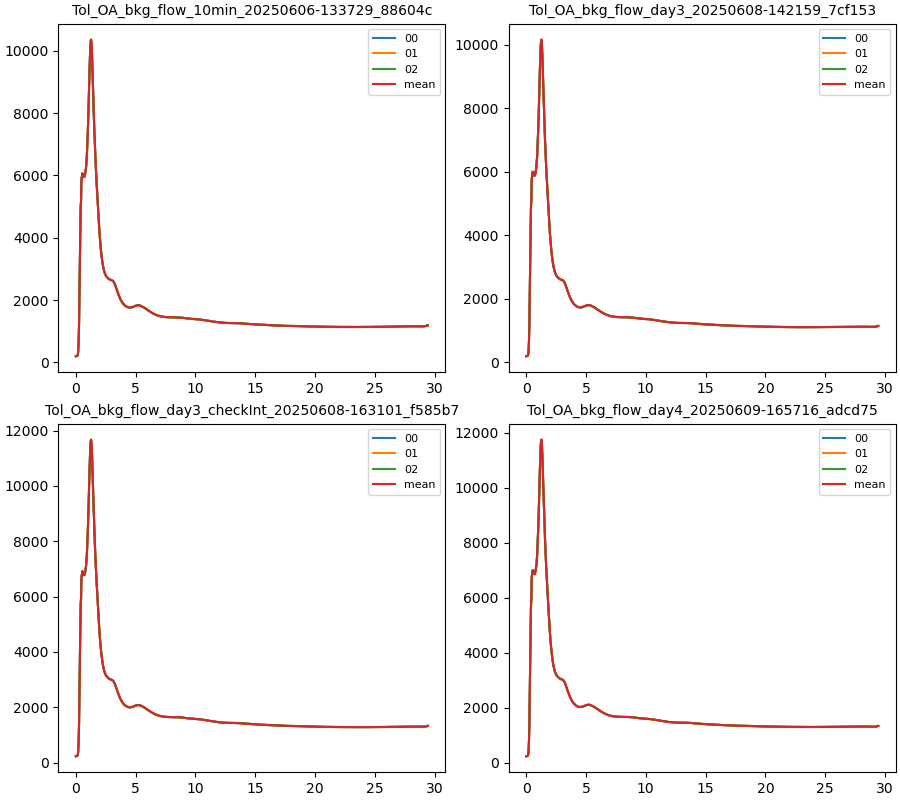

In [14]:
rows = 2
cols = 2
f1, ax1 = plt.subplots(rows, cols, figsize = (9, 8), constrained_layout=True)
idx_array = np.arange(rows*cols).reshape(rows, cols)
legend_properties = {'weight':'regular', 'size':8}

time_stamp = []
for i in range(len(bkg_folder_list)):

    ## read chi in bkg_folder_list[i]
    bkg_chi_path = os.path.join(bkg_folder_list[i], 'integration', '**_q.chi')
    bkg_chi_list = glob.glob(bkg_chi_path)
    bkg_chi_list.sort()

    df_00 = pd.DataFrame()
    j = 0
    for bkg_chi in bkg_chi_list[-3:]:
        df_01 = pd.read_csv(bkg_chi, sep=' ', skiprows=1, names=['Q', 'I'])
        df_00[f'I_{j:02d}'] = df_01['I']
        fn_prefix = os.path.basename(bkg_chi[:-21])

        ## plot data individually
        idx_ax = np.argwhere(idx_array==i)
        ax1[idx_ax[0][0], idx_ax[0][1]].plot(df_01['Q'], df_01['I'], label=f'{j:02d}')
        ax1[idx_ax[0][0], idx_ax[0][1]].legend(prop=legend_properties)
        j += 1

    ## calculate average by pandas
    df_02 = pd.DataFrame()
    df_02['Q'] = df_01['Q']
    df_02['I_mean'] = df_00.mean(axis=1)

    ## plot average data and add title
    ax1[idx_ax[0][0], idx_ax[0][1]].set_title(fn_prefix, fontdict={'fontsize':10})
    ax1[idx_ax[0][0], idx_ax[0][1]].plot(df_02['Q'], df_02['I_mean'], label=f'mean')
    ax1[idx_ax[0][0], idx_ax[0][1]].legend(prop=legend_properties)

    ## get readable_time from metadata
    yaml_path = glob.glob(os.path.join(bkg_folder_list[i], 'meta', f'**{fn_prefix}**.yaml'))[-1]
    with open(yaml_path, 'r') as file:
        metadata = yaml.safe_load(file)
    time_stamp.append(metadata['readable_time'])
    file.close()

    ## save average bkg as chi files
    bkg_mean_fn = os.path.join(bkg_folder_list[i], f'{fn_prefix}_mean.chi')
    df_02.to_csv(bkg_mean_fn, sep=' ', index=False, float_format='{:.8e}'.format)
    bkg_mean_list.append(bkg_mean_fn)



In [15]:
bkg_chi_list[-3:]

['/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day4/integration/Tol_OA_bkg_flow_day4_20250609-165716_adcd75_primary-1_mean_q.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day4/integration/Tol_OA_bkg_flow_day4_20250609-165716_adcd75_primary-2_mean_q.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day4/integration/Tol_OA_bkg_flow_day4_20250609-165716_adcd75_primary-3_mean_q.chi']

In [16]:
fn_prefix

'Tol_OA_bkg_flow_day4_20250609-165716_adcd75'

In [17]:
bkg_mean_list

['/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_10min/Tol_OA_bkg_flow_10min_20250606-133729_88604c_mean.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day3/Tol_OA_bkg_flow_day3_20250608-142159_7cf153_mean.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day3_checkInt/Tol_OA_bkg_flow_day3_checkInt_20250608-163101_f585b7_mean.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day4/Tol_OA_bkg_flow_day4_20250609-165716_adcd75_mean.chi']

### Remove undersired bkg from the list

In [18]:
bkg_folder_list.pop(1)
time_stamp.pop(1)

'20250608-142159'

In [19]:
bkg_folder_list

['/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_10min',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day3_checkInt',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day4']

In [43]:
bkg_mean_list.pop(1)
bkg_mean_list

['/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_10min/Tol_OA_bkg_flow_10min_20250606-133729_88604c_mean.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day3_checkInt/Tol_OA_bkg_flow_day3_checkInt_20250608-163101_f585b7_mean.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day4/Tol_OA_bkg_flow_day4_20250609-165716_adcd75_mean.chi']

In [20]:
time_stamp

['20250606-133729', '20250608-163101', '20250609-165716']

In [21]:
time_stamp[0] > time_stamp[1]

False

In [22]:
time_stamp[0] < time_stamp[1]

True

## Make subfolders to resort iq data

In [23]:
iqgr_folder

'/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr'

In [24]:
sort_bkg = ['bkg_10min', 'bkg_day3', 'bkg_day4']

In [25]:
iq_bkg_sorted = []
for sub_folder in sort_bkg:
    new_folder = os.path.join(iqgr_folder, sub_folder)
    os.makedirs(new_folder, exist_ok=True)
    iq_bkg_sorted.append(new_folder)

In [26]:
iq_bkg_sorted

['/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/bkg_10min',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/bkg_day3',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/bkg_day4']

## Resort the iq data accroding to time stamp

In [27]:
iq_chi_list = glob.glob(os.path.join(iqgr_folder, '**.chi'))
iq_chi_list.sort()
print(*iq_chi_list[:10], sep = '\n')

/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_000_Br_040_Pb_058_OLA_026_PF_010_Tol_620_20250608-175222_4e1986_scattering-1_mean_q.chi
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_000_Br_040_Pb_063_OLA_021_PF_010_Tol_620_20250608-193204_9d3865_scattering-1_mean_q.chi
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_000_Br_060_Pb_180_PF_020_Tol_1200_20250607-123615_ad347c_scattering-1_mean_q.chi
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_000_Br_100_Pb_100_OLA_020_PF_018_Tol_1100_20250607-195546_91db25_scattering-1_mean_q.chi
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_000_Br_120_Pb_060_OLA_005_PF_015_Tol_925_20250607-210829_ee525f_scattering-1_mean_q.chi
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_000_Br_120_Pb_120_PF_020_Tol_1200_20250607-021742_d0b4bc_scattering-1_mean_q.chi
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3

In [28]:
sort_key = lambda iq_chi: get_timestamp_by_fn(iq_chi)
iq_time_sorted = sorted(iq_chi_list, key=sort_key)

In [29]:
print(*iq_time_sorted[:10], sep = '\n')

/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_rich_1-0-1_20250606-164700_db00fc_primary-1_mean_q.chi
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_rich_1-0-1_v2_20250606-182331_854c30_primary-1_mean_q.chi
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_rich_1-0-1_80uL_20250606-211441_860dbf_primary-1_mean_q.chi
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_020_Br_040_Pb_180_PF_020_Tol_1200_20250606-215430_c1a394_scattering-1_mean_q.chi
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_180_Br_040_Pb_020_PF_020_Tol_1200_20250606-221450_9e13eb_scattering-1_mean_q.chi
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_080_Br_080_Pb_080_PF_020_Tol_1200_20250606-223512_d03d55_scattering-1_mean_q.chi
/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/Cs_020_Br_080_Pb_140_PF_020_Tol_1200_20250606-225646_a26ebc_scattering-1_mean_q.chi
/Users

## Copy iq data into the corresponding bkg folder

In [30]:
iqfolder_path

'/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Cs**'

In [31]:
iqgr_folder

'/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr'

In [32]:
bkg_mean_list

['/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_10min/Tol_OA_bkg_flow_10min_20250606-133729_88604c_mean.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day3/Tol_OA_bkg_flow_day3_20250608-142159_7cf153_mean.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day3_checkInt/Tol_OA_bkg_flow_day3_checkInt_20250608-163101_f585b7_mean.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day4/Tol_OA_bkg_flow_day4_20250609-165716_adcd75_mean.chi']

In [33]:
for i in range(len(iq_chi_list)):
    iq_time = get_timestamp_by_fn(iq_chi_list[i])
    
    if (iq_time>time_stamp[0]) and (iq_time<time_stamp[1]):
        shutil.copy2(iq_chi_list[i], os.path.join(iqgr_folder, sort_bkg[0]))
        print(f'Copy {os.path.basename(iq_chi_list[i])} to {sort_bkg[0]} folder\n')

    elif (iq_time>time_stamp[1]) and (iq_time<time_stamp[2]):
        shutil.copy2(iq_chi_list[i], os.path.join(iqgr_folder, sort_bkg[1]))
        print(f'Copy {os.path.basename(iq_chi_list[i])} to {sort_bkg[1]} folder\n')

    elif (iq_time>time_stamp[2]):
        shutil.copy2(iq_chi_list[i], os.path.join(iqgr_folder, sort_bkg[2]))
        print(f'Copy {os.path.basename(iq_chi_list[i])} to {sort_bkg[2]} folder\n')
        
    

Copy Cs_000_Br_040_Pb_058_OLA_026_PF_010_Tol_620_20250608-175222_4e1986_scattering-1_mean_q.chi to bkg_day3 folder

Copy Cs_000_Br_040_Pb_063_OLA_021_PF_010_Tol_620_20250608-193204_9d3865_scattering-1_mean_q.chi to bkg_day3 folder

Copy Cs_000_Br_060_Pb_180_PF_020_Tol_1200_20250607-123615_ad347c_scattering-1_mean_q.chi to bkg_10min folder

Copy Cs_000_Br_100_Pb_100_OLA_020_PF_018_Tol_1100_20250607-195546_91db25_scattering-1_mean_q.chi to bkg_10min folder

Copy Cs_000_Br_120_Pb_060_OLA_005_PF_015_Tol_925_20250607-210829_ee525f_scattering-1_mean_q.chi to bkg_10min folder

Copy Cs_000_Br_120_Pb_120_PF_020_Tol_1200_20250607-021742_d0b4bc_scattering-1_mean_q.chi to bkg_10min folder

Copy Cs_000_Br_142_Pb_091_OLA_006_PF_020_Tol_1200_20250608-185217_3486c9_scattering-1_mean_q.chi to bkg_day3 folder

Copy Cs_000_Br_143_Pb_093_OLA_000_PF_020_Tol_1182_20250608-205851_e5c3d6_scattering-1_mean_q.chi to bkg_day3 folder

Copy Cs_000_Br_180_Pb_060_PF_020_Tol_1200_20250607-023725_6129b4_scattering-1_m

## Use get_gr() to reduce I(Q) into G(r)

In [34]:
iq_bkg_sorted

['/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/bkg_10min',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/bkg_day3',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/iqgr/bkg_day4']

In [35]:
bkg_mean_list

['/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_10min/Tol_OA_bkg_flow_10min_20250606-133729_88604c_mean.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day3/Tol_OA_bkg_flow_day3_20250608-142159_7cf153_mean.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day3_checkInt/Tol_OA_bkg_flow_day3_checkInt_20250608-163101_f585b7_mean.chi',
 '/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day4/Tol_OA_bkg_flow_day4_20250609-165716_adcd75_mean.chi']

INFO:set config._backgroundfiles = []
INFO:diffpy.pdfgetx.user:set config._backgroundfiles = []
INFO:set config._bgscales_values = ['1.0']
INFO:diffpy.pdfgetx.user:set config._bgscales_values = ['1.0']
INFO:reset config.configfile = None
INFO:diffpy.pdfgetx.user:reset config.configfile = None
INFO:reset config.configsection = None
INFO:diffpy.pdfgetx.user:reset config.configsection = None
INFO:reset config.dataformat = twotheta
INFO:diffpy.pdfgetx.user:reset config.dataformat = twotheta
INFO:reset config.inputfiles = []
INFO:diffpy.pdfgetx.user:reset config.inputfiles = []
INFO:reset config.backgroundfiles = []
INFO:diffpy.pdfgetx.user:reset config.backgroundfiles = []
INFO:set config._backgroundfiles = []
INFO:diffpy.pdfgetx.user:set config._backgroundfiles = []
INFO:reset config.formfactorfile = 
INFO:diffpy.pdfgetx.user:reset config.formfactorfile = 
INFO:reset config.datapath = []
INFO:diffpy.pdfgetx.user:reset config.datapath = []
INFO:reset config.output = 
INFO:diffpy.pdfgetx.us

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99504446]) by auto_bkg



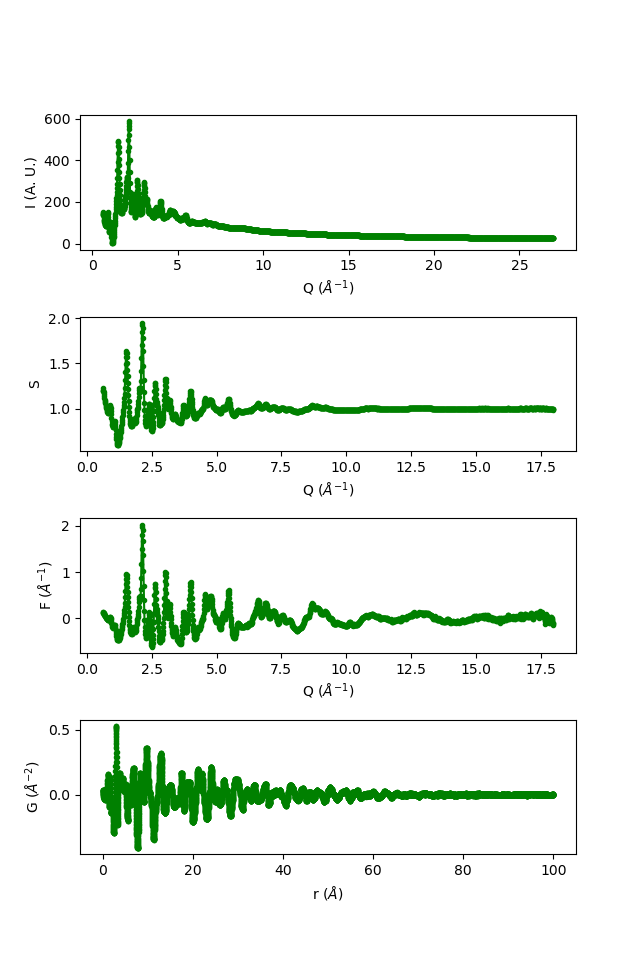


*** Cs_020_Br_085_Pb_022_OLA_001_PF_011_Tol_640_20250610-041311_acc484_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.85476198]) by auto_bkg



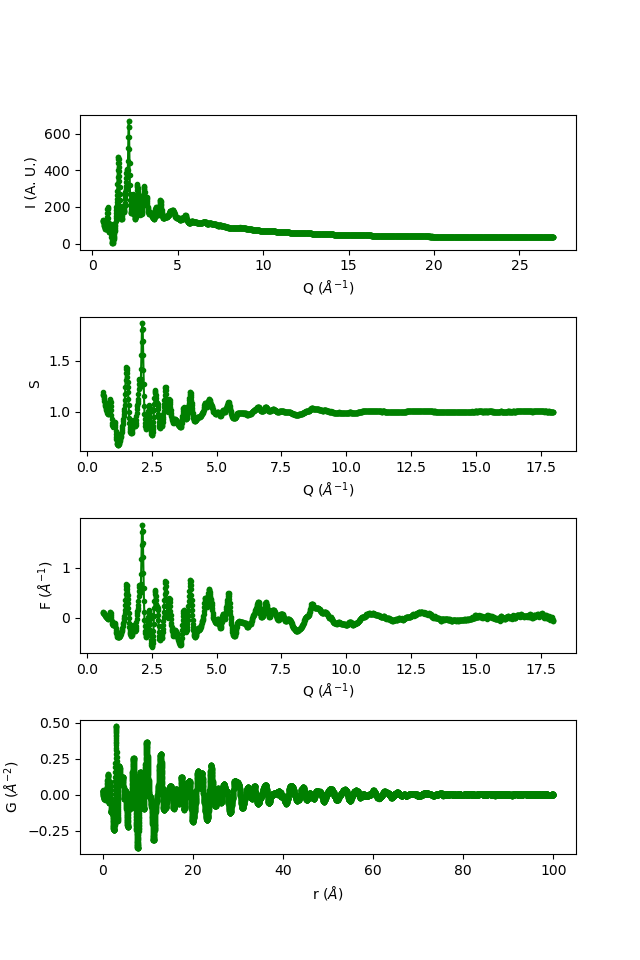


*** Cs_020_Br_070_Pb_022_OLA_000_PF_009_Tol_560_20250610-055108_9a2bf0_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.98805723]) by auto_bkg



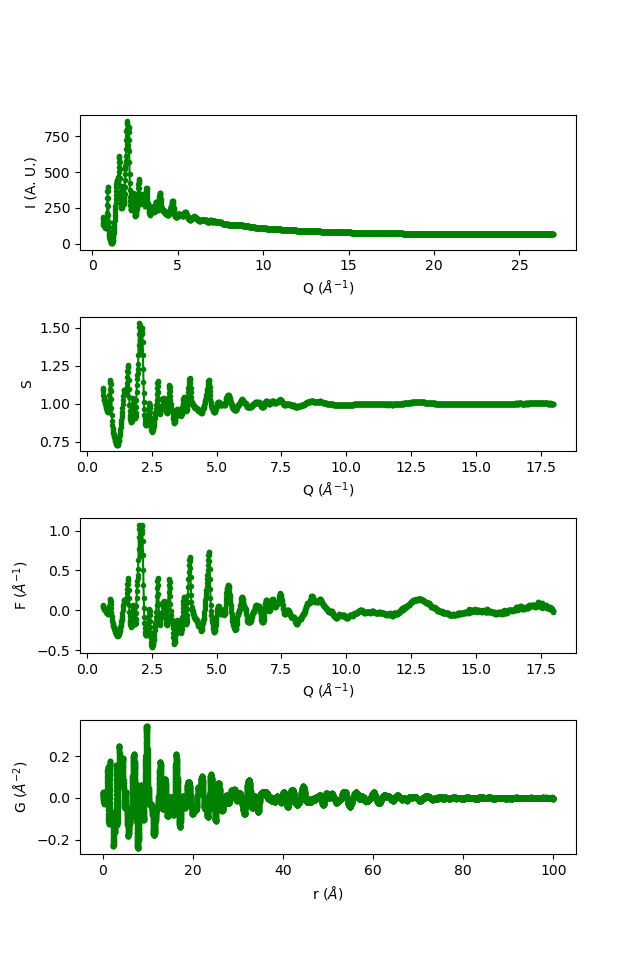


*** Cs_031_Br_162_Pb_011_OLA_036_PF_020_Tol_1197_20250609-235551_ea83af_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.98847534]) by auto_bkg



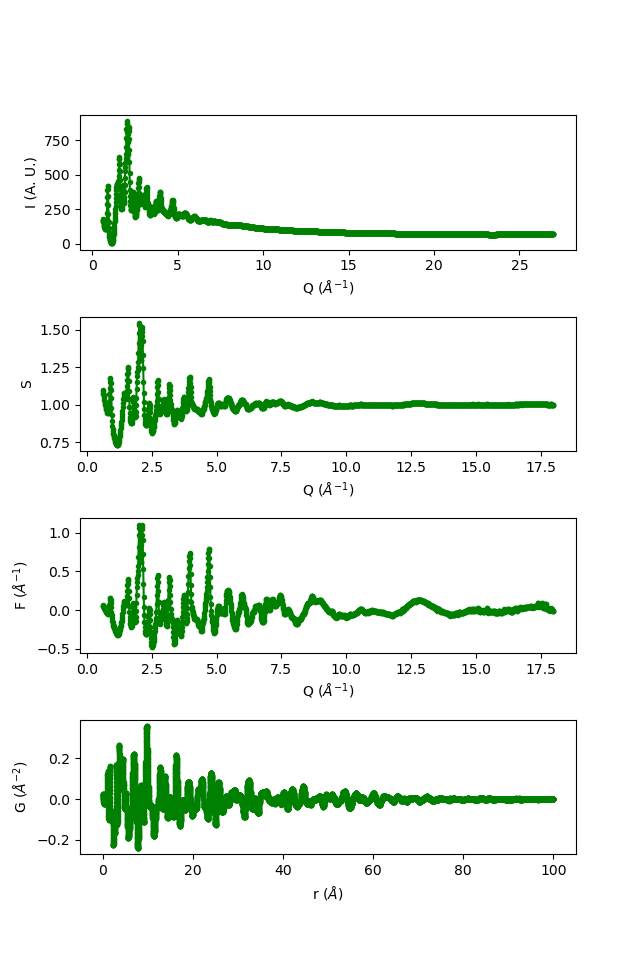


*** Cs_016_Br_080_Pb_006_OLA_018_PF_010_Tol_600_20250610-001750_315214_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([1.00060639]) by auto_bkg



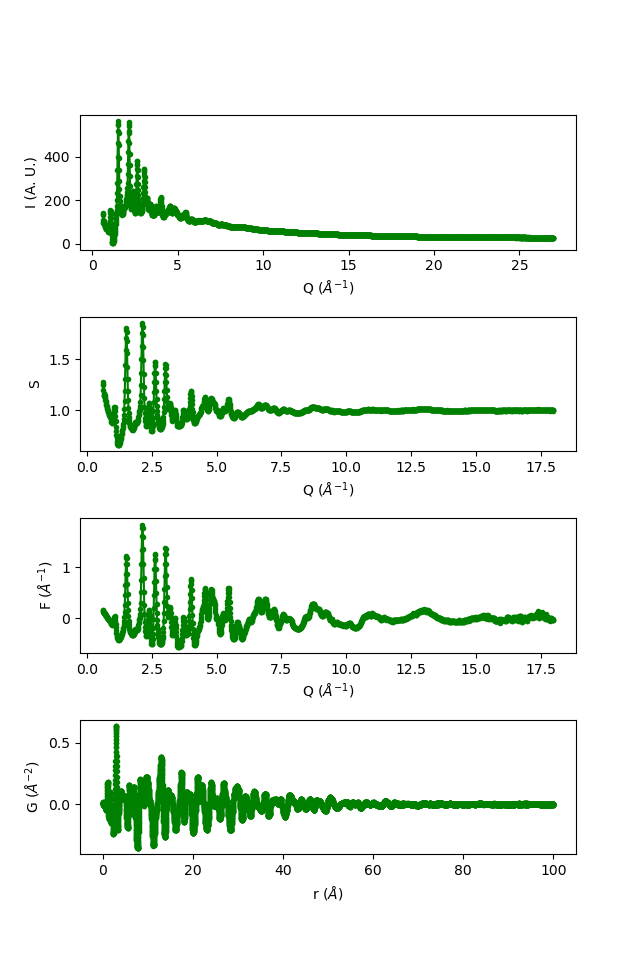


*** Cs_043_Br_131_Pb_083_OLA_000_PF_021_Tol_1285_20250609-181255_d95074_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99444233]) by auto_bkg



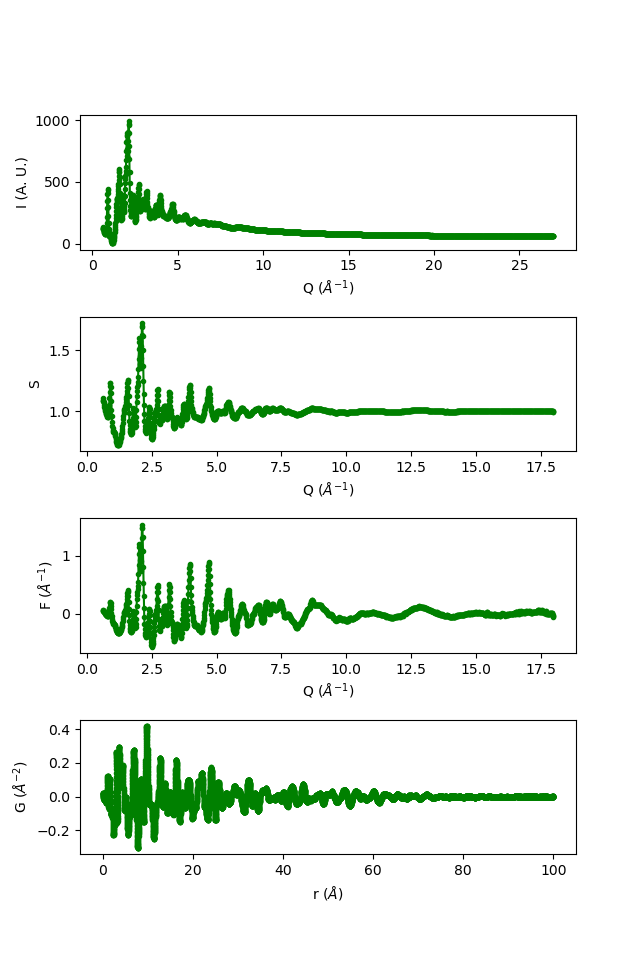


*** Cs_030_Br_150_Pb_020_OLA_010_PF_018_Tol_1050_20250610-003646_86af6b_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99728351]) by auto_bkg



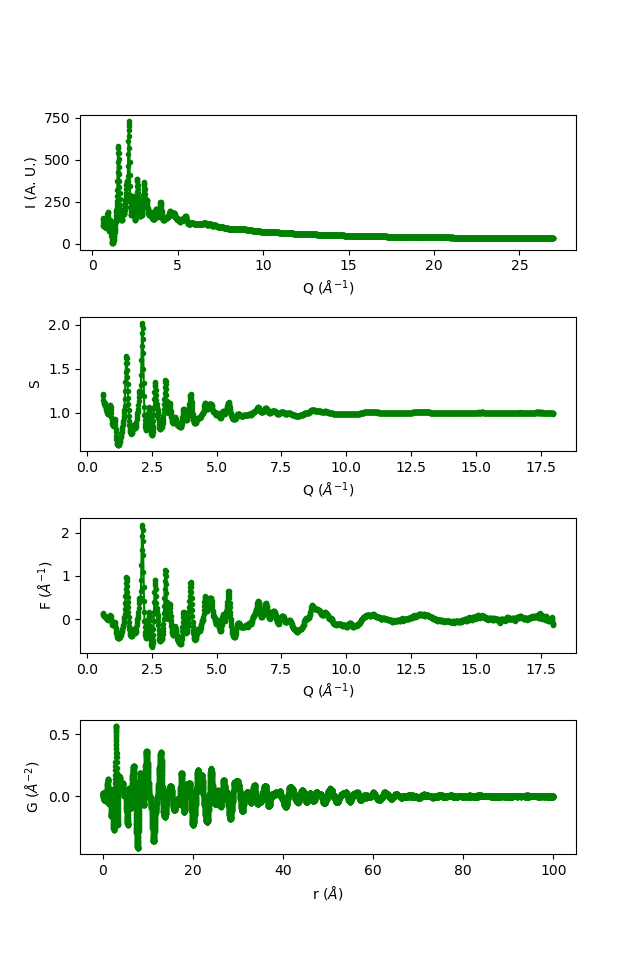


*** Cs_028_Br_079_Pb_029_OLA_000_PF_011_Tol_682_20250610-043330_58afe3_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99947757]) by auto_bkg



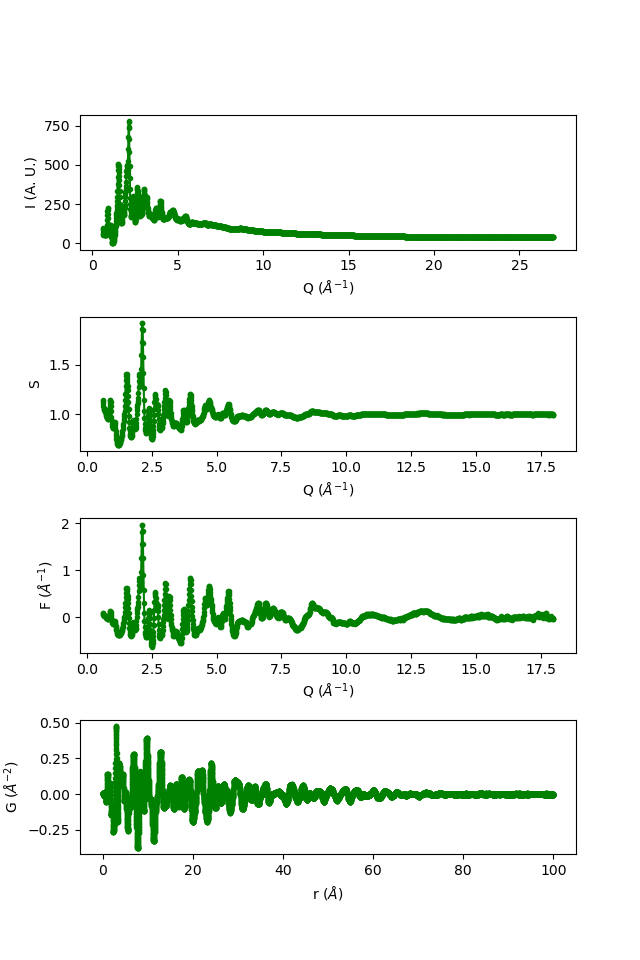


*** Cs_028_Br_078_Pb_029_OLA_000_PF_011_Tol_673_20250609-205333_44c93f_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99879972]) by auto_bkg



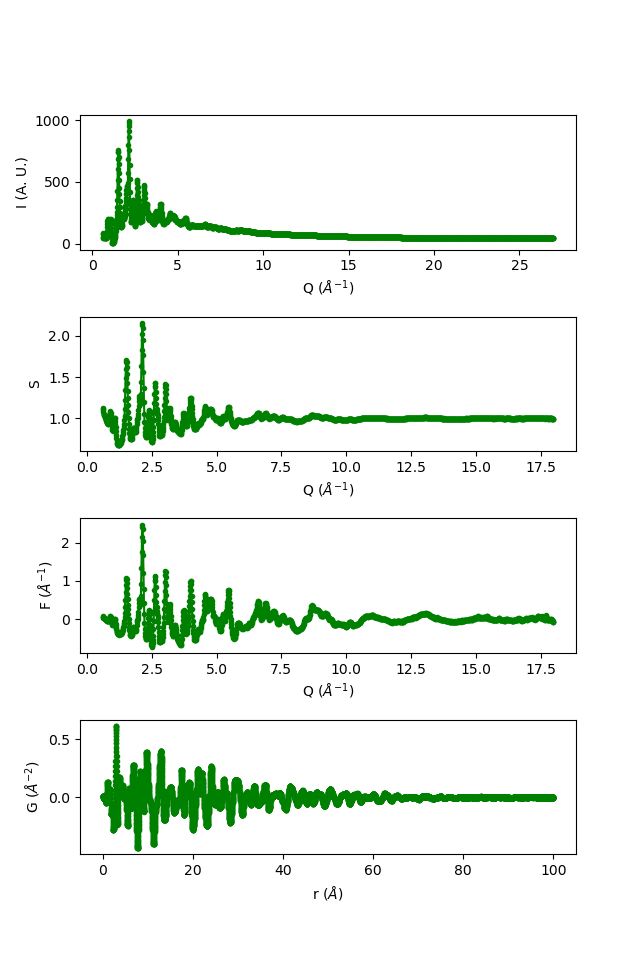


*** Cs_027_Br_090_Pb_040_OLA_000_PF_013_Tol_785_20250609-211638_291d1d_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([1.00397525]) by auto_bkg



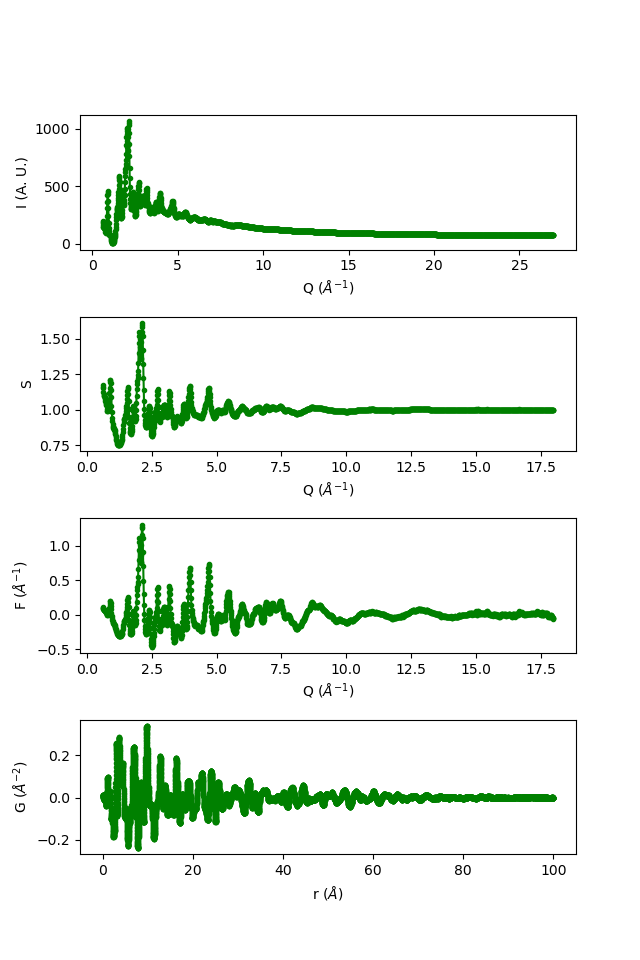


*** Cs_101_Br_070_Pb_040_OLA_002_PF_018_Tol_1065_20250610-013630_922f95_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.9970341]) by auto_bkg



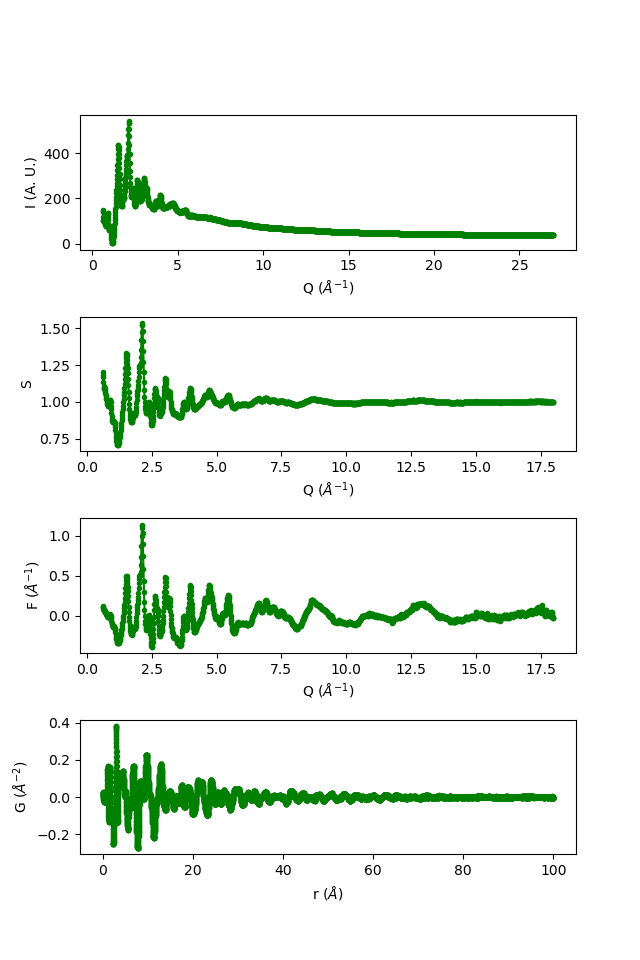


*** Cs_059_Br_104_Pb_058_OLA_017_PF_020_Tol_1190_20250609-193150_d50931_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([1.00619321]) by auto_bkg



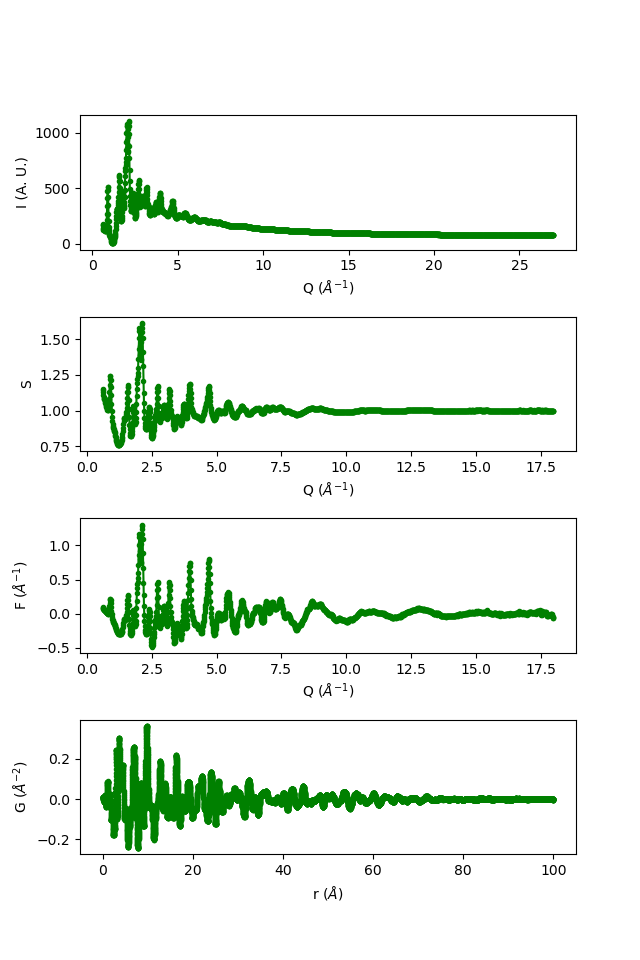


*** Cs_050_Br_045_Pb_020_OLA_002_PF_010_Tol_585_20250610-021626_c2b71e_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.9990306]) by auto_bkg



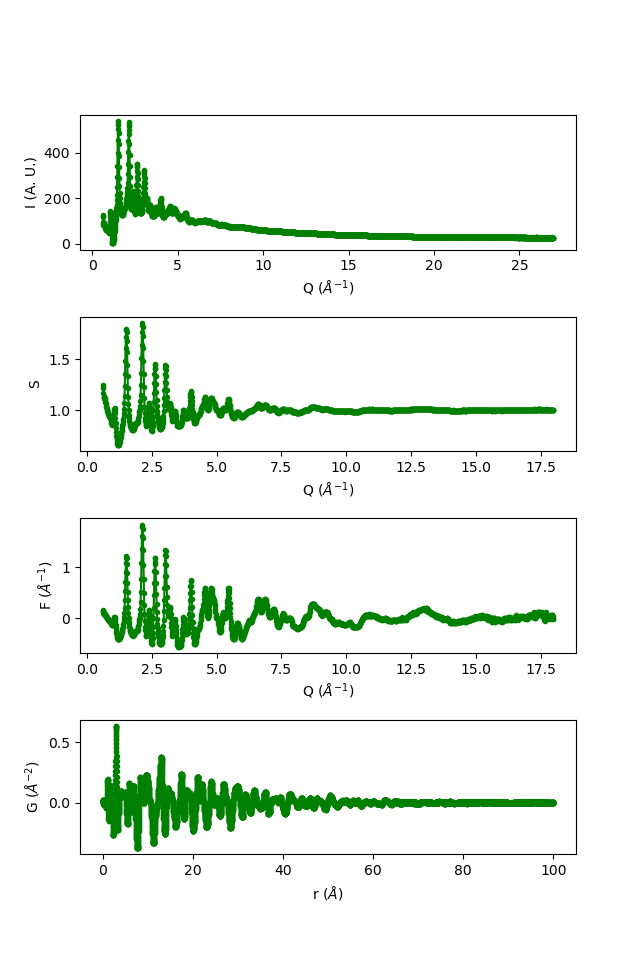


*** Cs_033_Br_141_Pb_080_OLA_002_PF_021_Tol_1280_20250609-175317_8364d6_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([1.00205671]) by auto_bkg



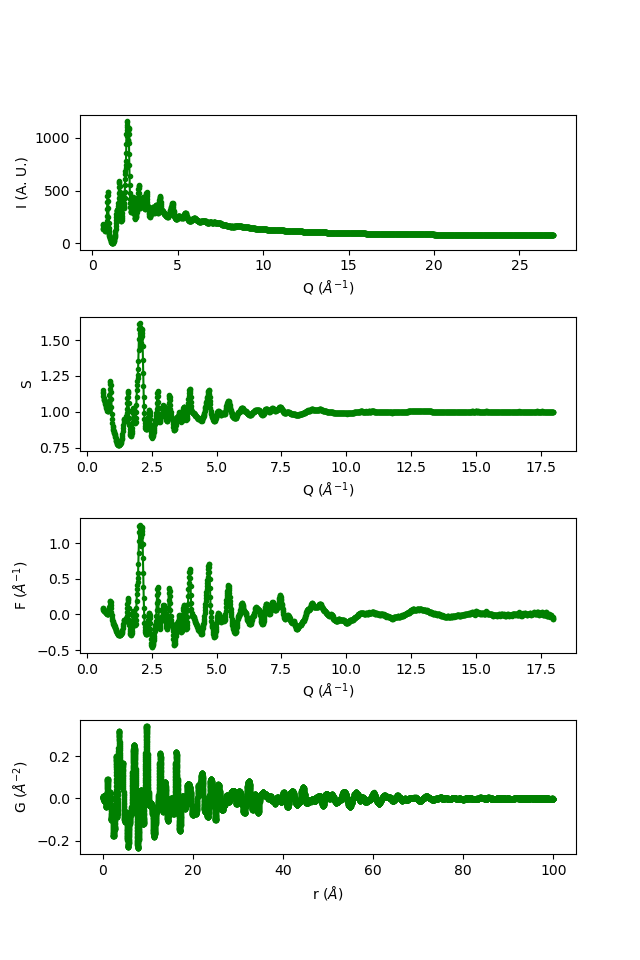


*** Cs_120_Br_090_Pb_025_OLA_005_PF_020_Tol_1200_20250610-015508_1e9846_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99520687]) by auto_bkg



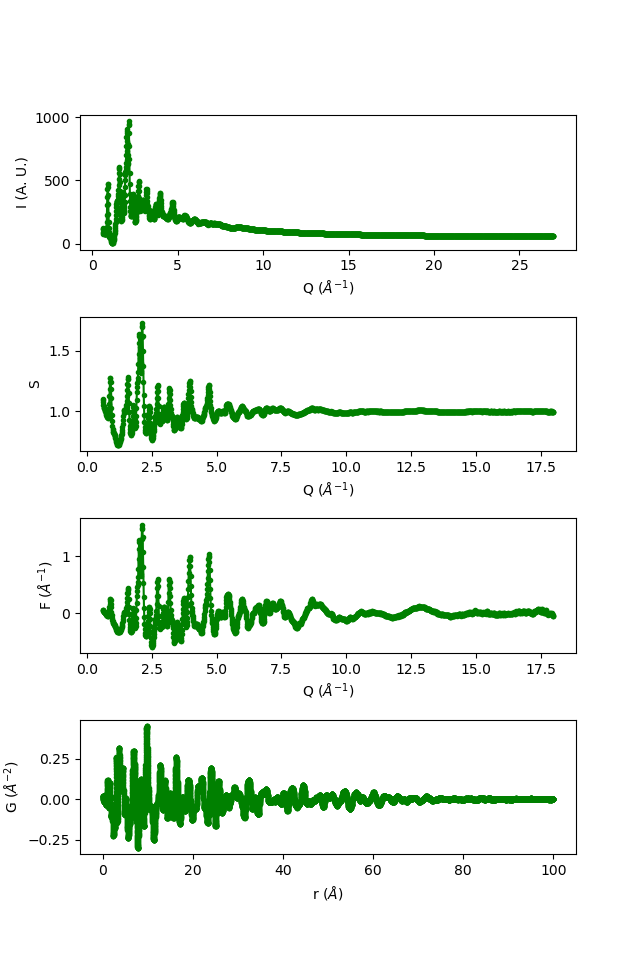


*** Cs_015_Br_075_Pb_010_OLA_002_PF_008_Tol_510_20250610-005832_1b0770_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([1.00223788]) by auto_bkg



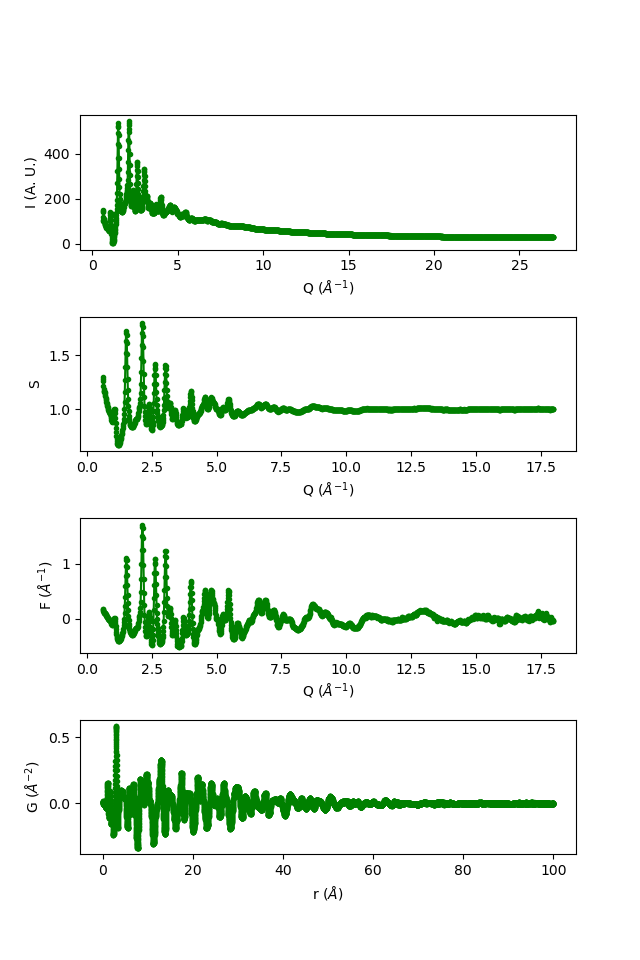


*** Cs_053_Br_121_Pb_086_OLA_000_PF_022_Tol_1300_20250609-183232_157555_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([1.00247928]) by auto_bkg



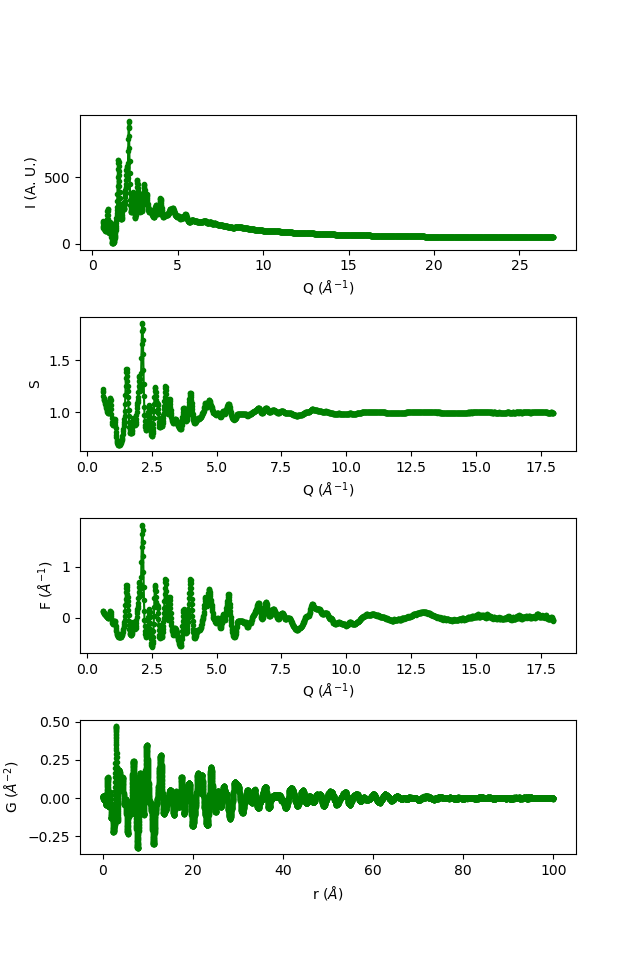


*** Cs_082_Br_200_Pb_118_OLA_000_PF_033_Tol_1996_20250609-221542_fc4b69_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([1.0028432]) by auto_bkg



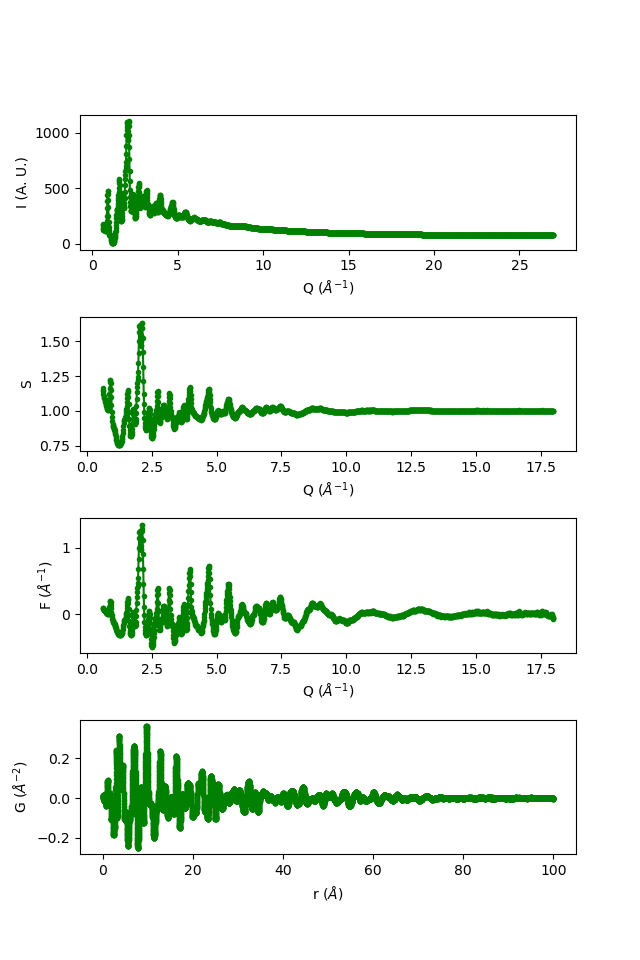


*** Cs_114_Br_082_Pb_033_OLA_000_PF_019_Tol_1144_20250610-011735_ff2a42_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99953787]) by auto_bkg



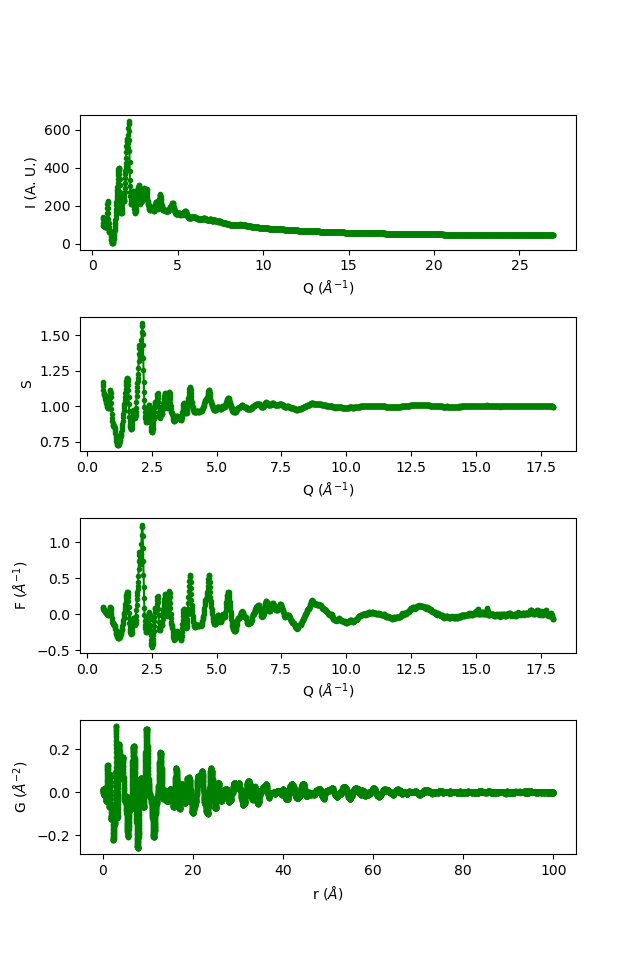


*** Cs_074_Br_110_Pb_043_OLA_008_PF_020_Tol_1175_20250609-203129_12cfba_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99453349]) by auto_bkg



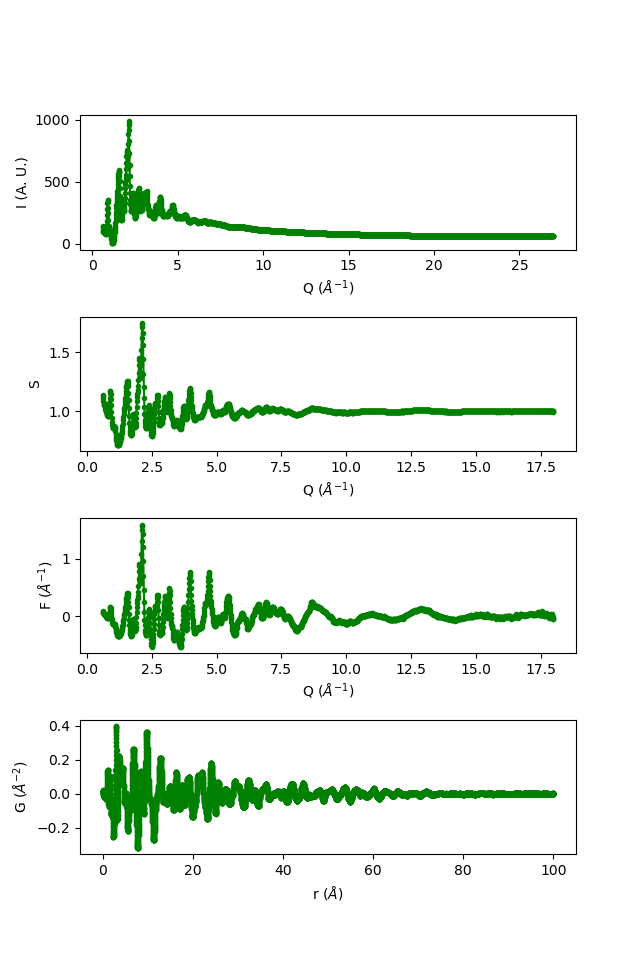


*** Cs_030_Br_090_Pb_040_OLA_015_PF_015_Tol_875_20250609-231619_1ec05d_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99830023]) by auto_bkg



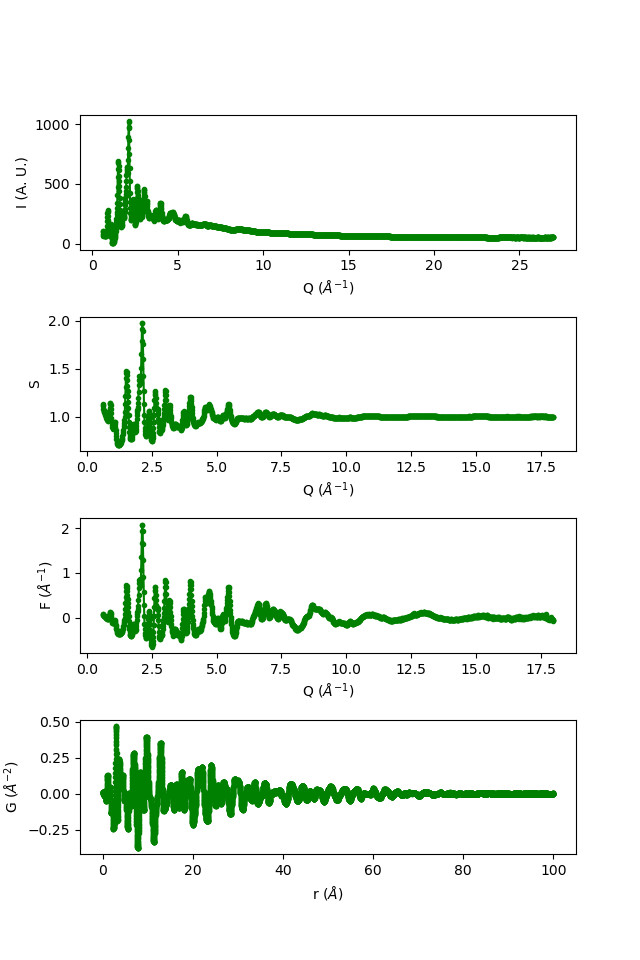


*** Cs_037_Br_070_Pb_030_OLA_002_PF_012_Tol_695_20250609-213805_2e9a36_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99834533]) by auto_bkg



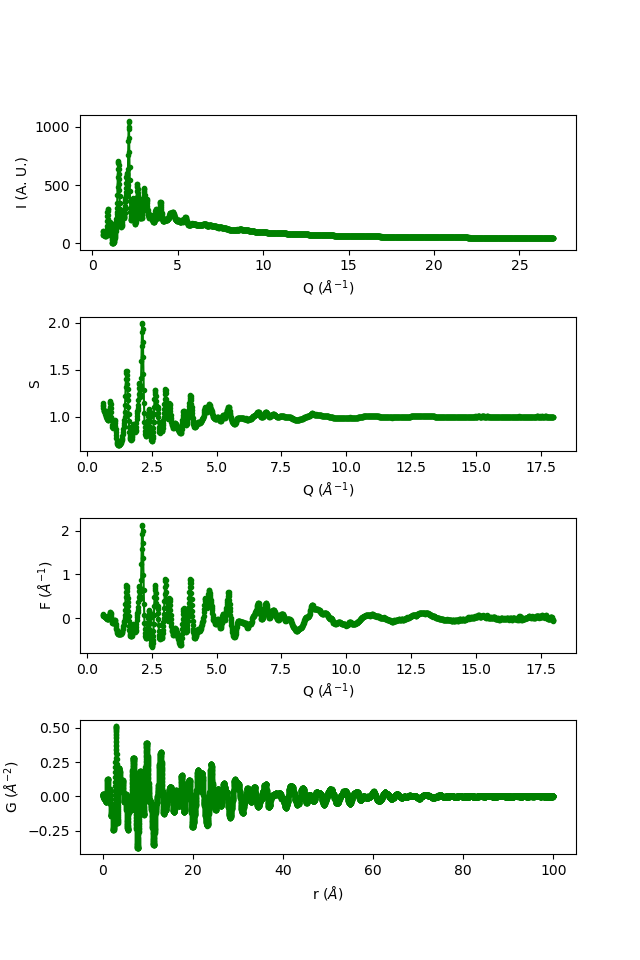


*** Cs_040_Br_100_Pb_055_OLA_000_PF_016_Tol_975_20250609-225648_fcded6_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([1.00317063]) by auto_bkg



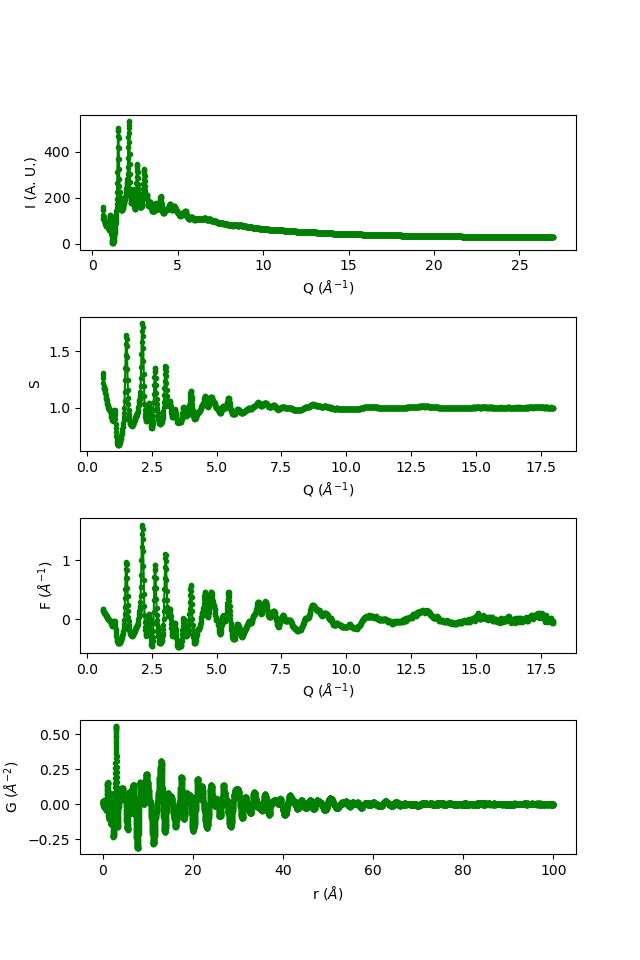


*** Cs_063_Br_111_Pb_089_OLA_000_PF_022_Tol_1315_20250609-185207_c202cd_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99866906]) by auto_bkg



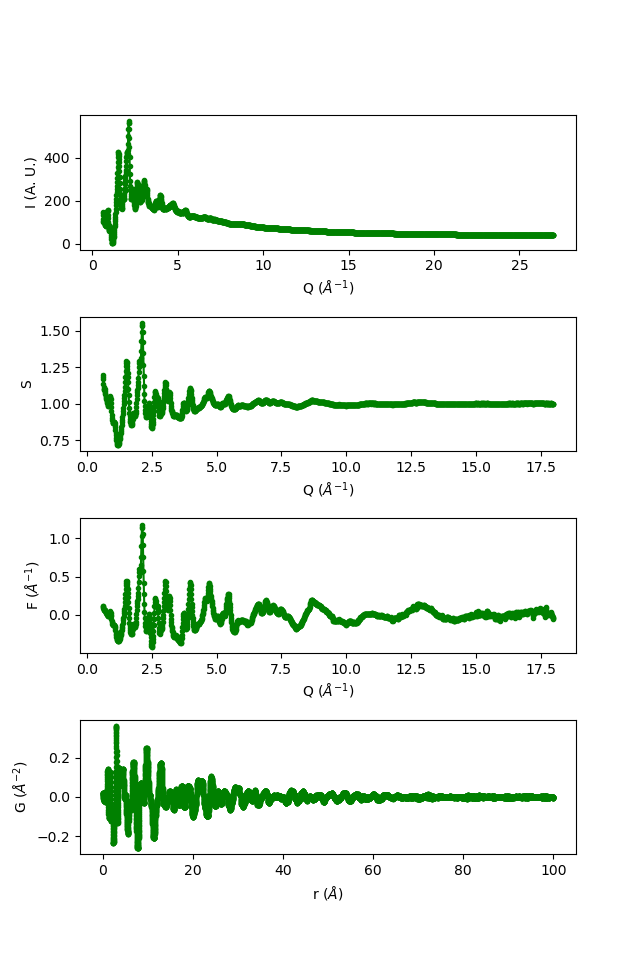


*** Cs_064_Br_106_Pb_053_OLA_014_PF_020_Tol_1185_20250609-195143_5d181d_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([1.00592222]) by auto_bkg



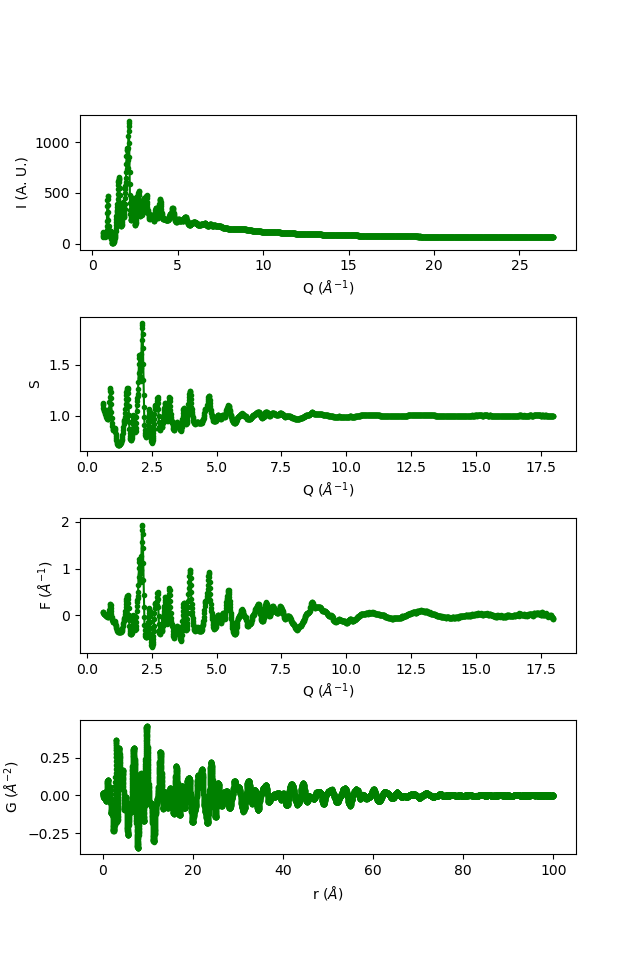


*** Cs_041_Br_170_Pb_044_OLA_000_PF_021_Tol_1275_20250610-023453_8d176d_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.9990842]) by auto_bkg



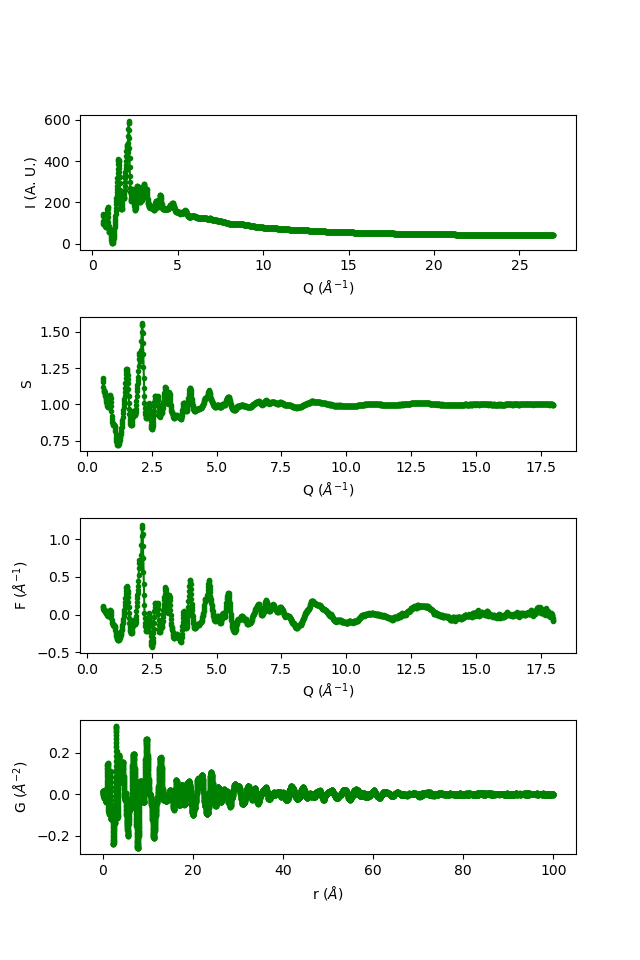


*** Cs_069_Br_108_Pb_048_OLA_011_PF_020_Tol_1180_20250609-201135_95b2c2_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99771203]) by auto_bkg



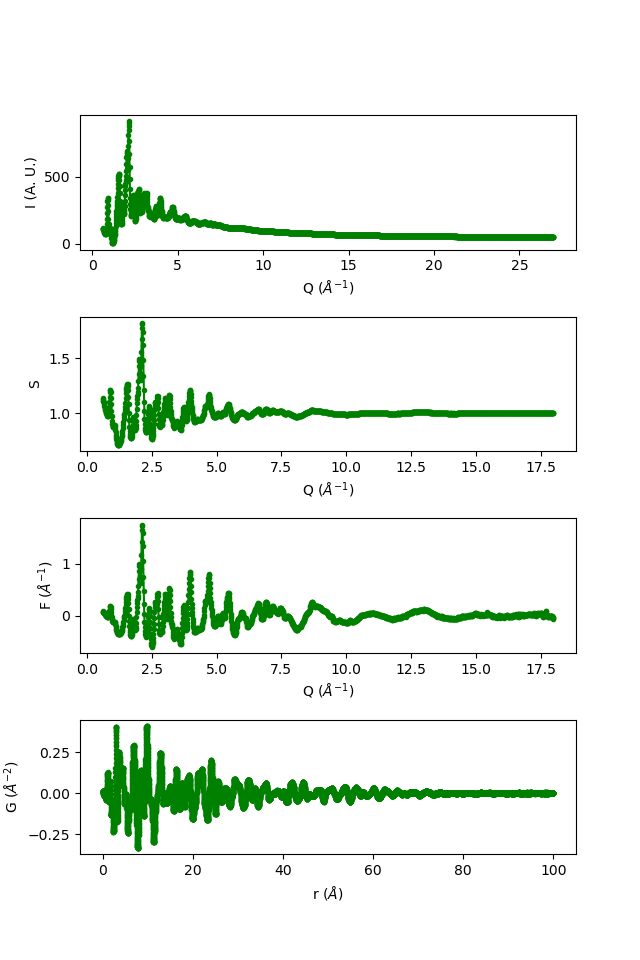


*** Cs_035_Br_082_Pb_030_OLA_005_PF_013_Tol_760_20250609-215803_746b39_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.96905138]) by auto_bkg



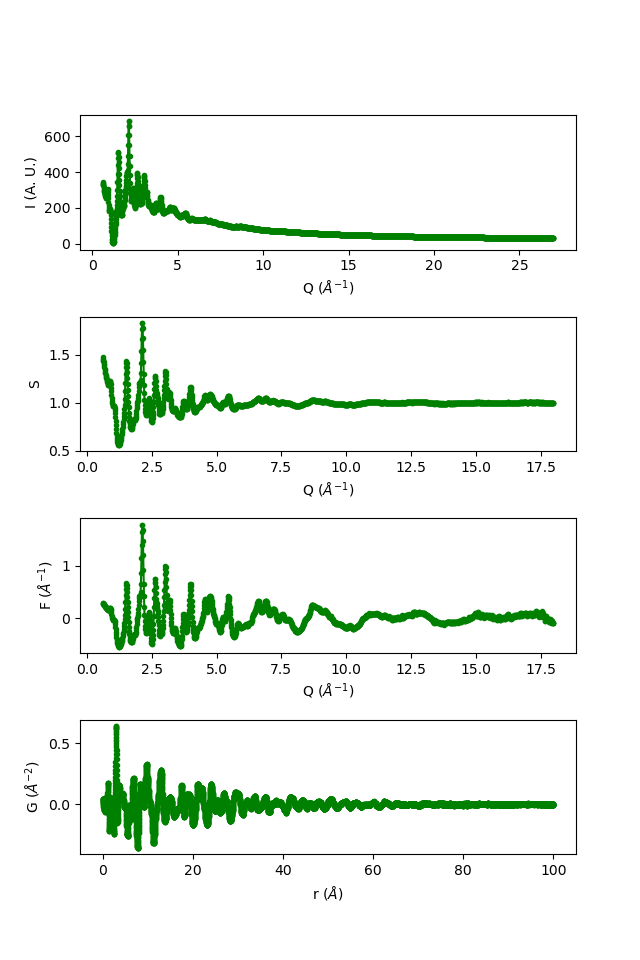


*** Cs_035_Br_085_Pb_040_OLA_002_PF_014_Tol_810_20250610-051525_1785b6_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.91330101]) by auto_bkg



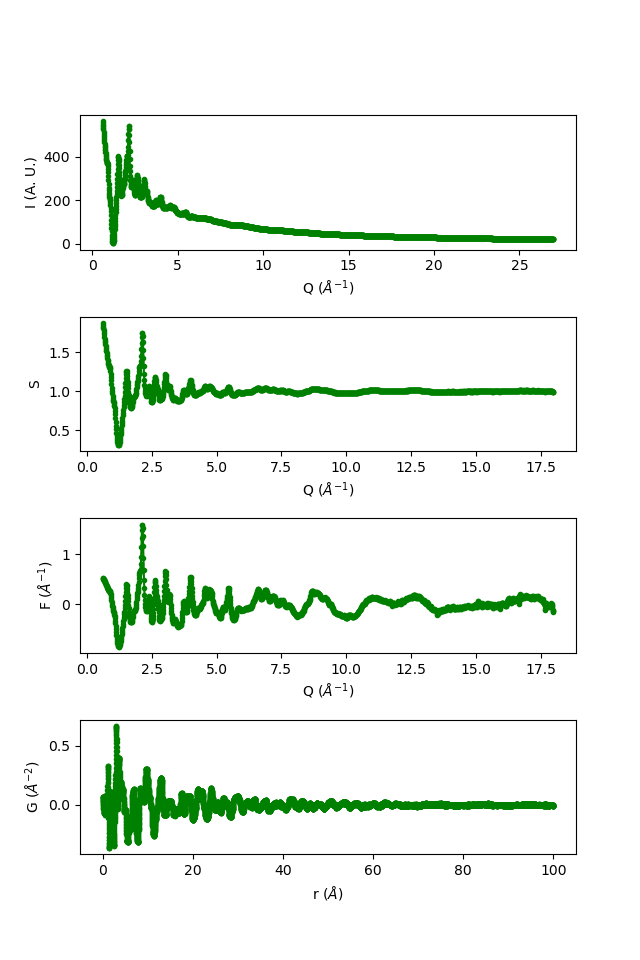


*** Cs_035_Br_160_Pb_036_OLA_010_PF_020_Tol_1205_20250610-033002_c8114c_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.98307799]) by auto_bkg



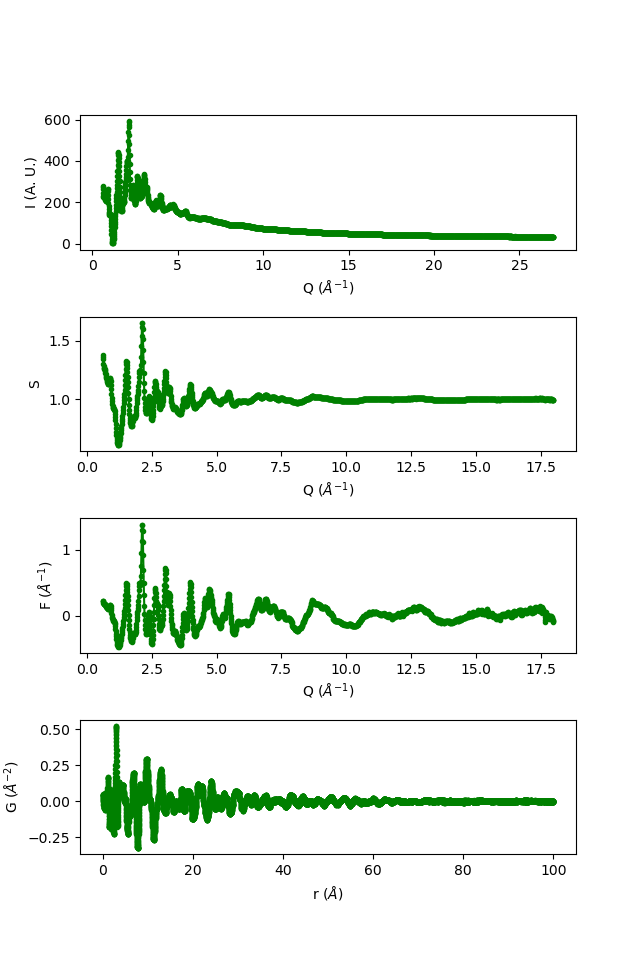


*** Cs_025_Br_075_Pb_025_OLA_010_PF_011_Tol_675_20250610-045357_bf9914_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99713634]) by auto_bkg



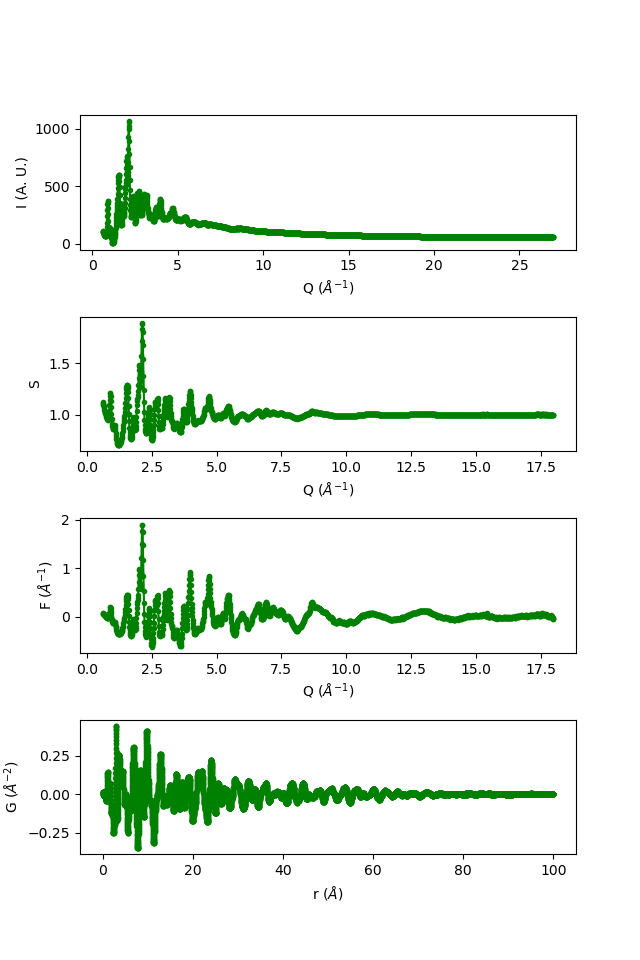


*** Cs_032_Br_092_Pb_040_OLA_002_PF_014_Tol_830_20250609-233714_bf8e84_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99370475]) by auto_bkg



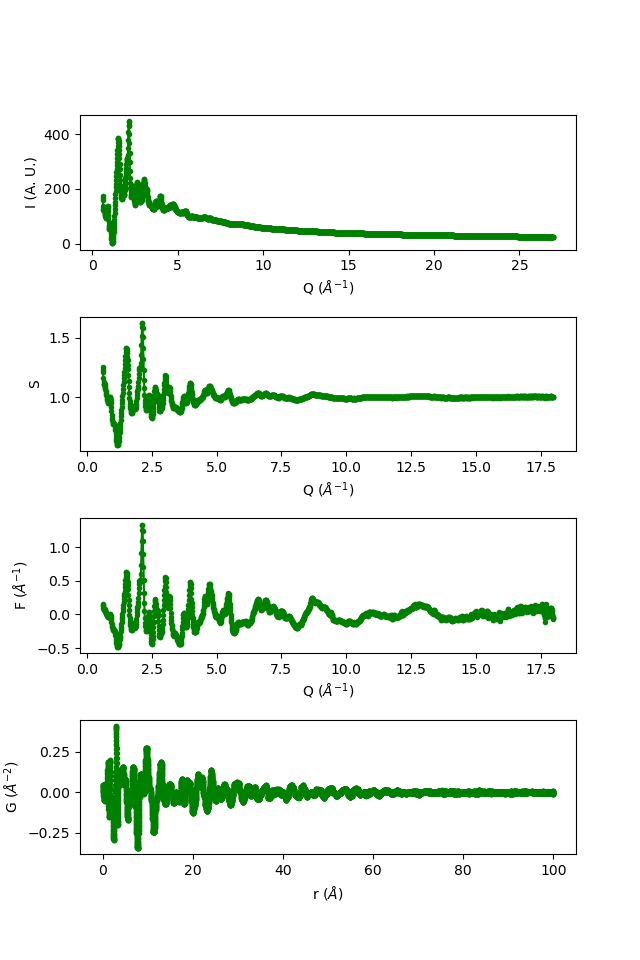


*** Cs_015_Br_070_Pb_016_OLA_005_PF_009_Tol_530_20250610-035232_0718dd_scattering-1_mean_q.gr saved!! ***

Found the bkg scale to minimize the integral

Update pdfconfig.bgscales[0] = array([0.99750699]) by auto_bkg



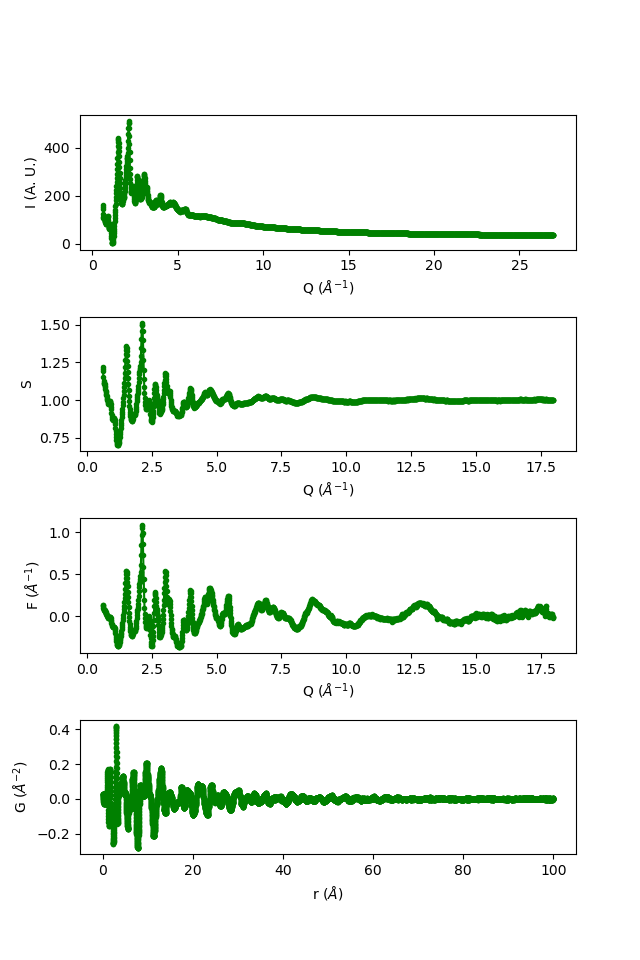


*** Cs_054_Br_102_Pb_063_OLA_020_PF_020_Tol_1195_20250609-191158_757e04_scattering-1_mean_q.gr saved!! ***



In [52]:
for bkg in iq_bkg_sorted[2:]:
    i = iq_bkg_sorted.index(bkg)
    iq_list = glob.glob(os.path.join(iq_bkg_sorted[i], '**q.chi'))
    cfg_list = glob.glob(os.path.join(iq_bkg_sorted[i], '**.cfg'))
    for j in range(len(iq_list[:])):
        saved_gr_prefix = os.path.basename(iq_list[j]).split('.')[0]
        sqfqgr_path, pdfconfig = get_gr(iq_list[j], 
                                        cfg_list[0], 
                                        bkg_mean_list[i], 
                                        iq_bkg_sorted[i], 
                                        saved_gr_prefix, 
                                        is_autobkg=True, 
                                        is_autoqmax=False, 
                                        ave_cutoff=0.008, 
                                        window_length=25, 
                                       )
    

In [48]:
i

1

In [49]:
bkg_mean_list[i]

'/Users/cheng-hunglin/Documents/Data_LDRD/Ghose_316490_d49d3e59/Tol_OA_bkg_flow_day3_checkInt/Tol_OA_bkg_flow_day3_checkInt_20250608-163101_f585b7_mean.chi'

In [50]:
plt.close('all')